In [31]:
ls

README.md*          checkpoints/  old_scores/  requirements.txt*  scores/
calibration.ipynb*  data/         plots/       run.sh*            src/


In [32]:
import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('seaborn')

/tmp/ipykernel_4510/2623516690.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  import matplotlib.pyplot as plt; plt.style.use('seaborn')


In [58]:
# dataset = 'mnist'
dataset = 'fashion'
# dataset = 'cifar'
model = 'cnn'
# model = 'resnet'

cen_val_scores = torch.load(f'scores/{dataset}/{model}_central_stage1_val_scores.pth', map_location=torch.device('cpu'))
cen_val_targets = torch.load(f'scores/{dataset}/{model}_central_stage1_val_targets.pth', map_location=torch.device('cpu'))
cen_test_scores = torch.load(f'scores/{dataset}/{model}_central_stage1_test_scores.pth', map_location=torch.device('cpu'))
cen_test_targets = torch.load(f'scores/{dataset}/{model}_central_stage1_test_targets.pth', map_location=torch.device('cpu'))

fed_val_scores = torch.load(f'scores/{dataset}/{model}_fedavg_stage1_val_scores.pth', map_location=torch.device('cpu'))
fed_val_targets = torch.load(f'scores/{dataset}/{model}_fedavg_stage1_val_targets.pth', map_location=torch.device('cpu'))
fed_test_scores = torch.load(f'scores/{dataset}/{model}_fedavg_stage1_test_scores.pth', map_location=torch.device('cpu'))
fed_test_targets = torch.load(f'scores/{dataset}/{model}_fedavg_stage1_test_targets.pth', map_location=torch.device('cpu'))

tct_val_scores = torch.load(f'scores/{dataset}/{model}_tct_stage2_val_scores.pth', map_location=torch.device('cpu'))
tct_val_targets = torch.load(f'scores/{dataset}/{model}_tct_stage2_val_targets.pth', map_location=torch.device('cpu'))
tct_test_scores = torch.load(f'scores/{dataset}/{model}_tct_stage2_test_scores.pth', map_location=torch.device('cpu'))
tct_test_targets = torch.load(f'scores/{dataset}/{model}_tct_stage2_test_targets.pth', map_location=torch.device('cpu'))

In [59]:
acc = lambda scores, targets: (scores.argmax(1) == targets).sum() / targets.size(0)

In [60]:
print('central', acc(cen_test_scores, cen_test_targets))
print('fedavg', acc(fed_test_scores, fed_test_targets))
print('tct', acc(tct_test_scores, tct_test_targets))

central tensor(0.8605)
fedavg tensor(0.8055)
tct tensor(0.8800)


In [61]:
def calc_bins(scores, targets):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(scores, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(scores[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (targets[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (scores[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes



In [62]:
def get_metrics(scores, targets):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(scores, targets)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

In [63]:
import matplotlib.patches as mpatches

def draw_reliability_graph(scores, targets):
    ECE, MCE = get_metrics(scores, targets)
    bins, _, bin_accs, _, _ = calc_bins(scores, targets)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    plt.show()

    # plt.savefig('calibrated_network.png', bbox_inches='tight')

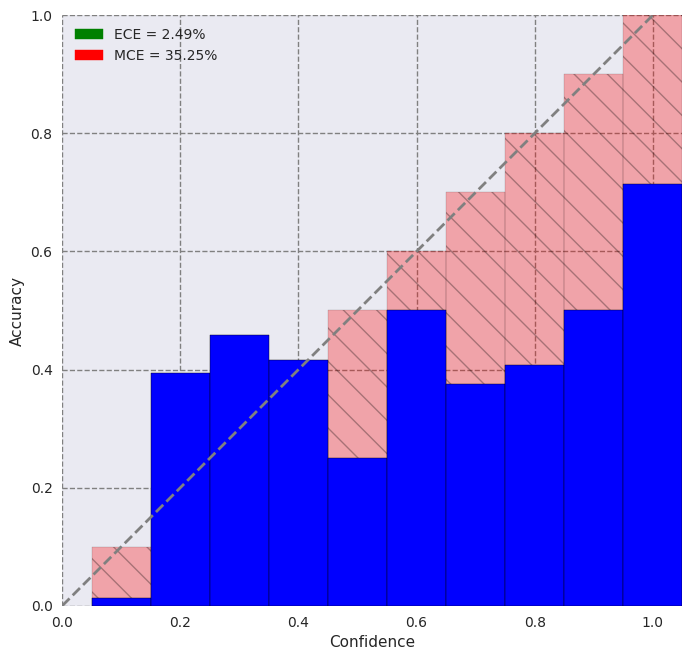

In [64]:
draw_reliability_graph(torch.softmax(cen_test_scores, 1), torch.nn.functional.one_hot(cen_test_targets))

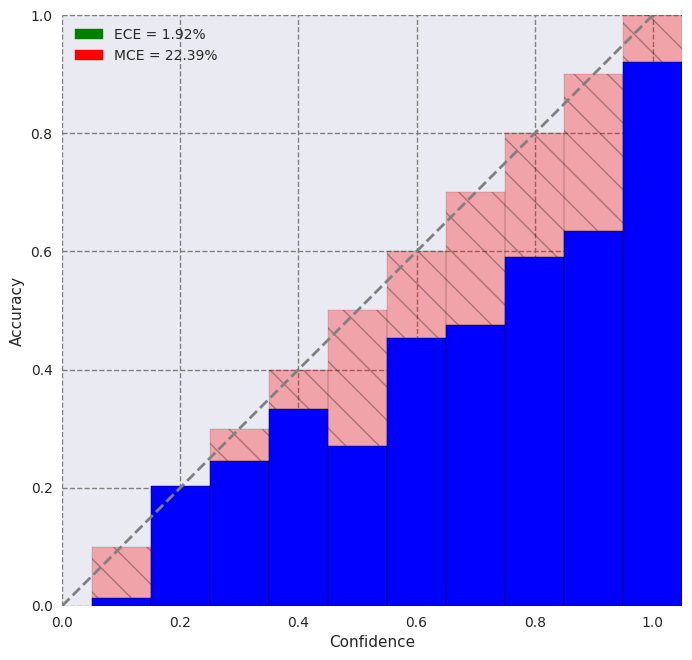

In [65]:
draw_reliability_graph(torch.softmax(fed_test_scores, 1), torch.nn.functional.one_hot(fed_test_targets))

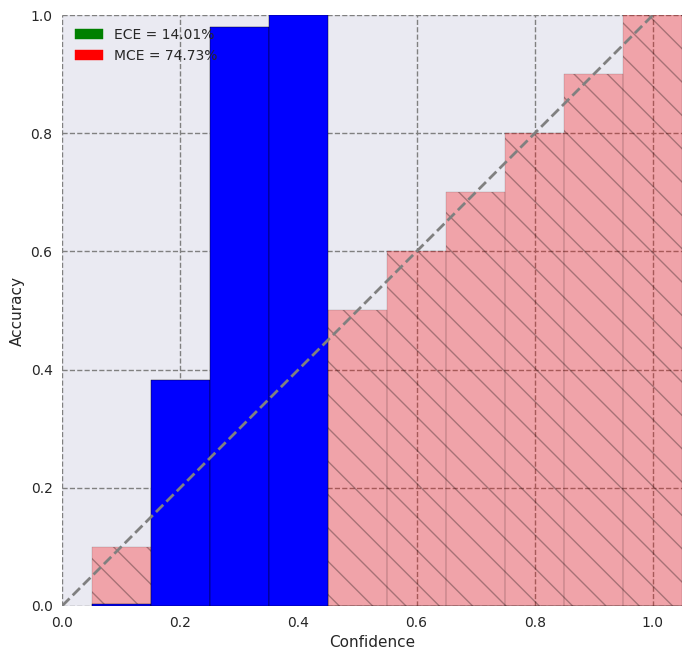

In [66]:
draw_reliability_graph(torch.softmax(tct_test_scores, 1), torch.nn.functional.one_hot(tct_test_targets))

In [67]:
def temp_scale(logits, labels, plot=True):
    temperature = torch.nn.Parameter(torch.ones(1))#.to('cuda' if torch.cuda.is_available() else 'cpu')
    # print(temperature.is_leaf)
    criterion = torch.nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = torch.optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

    temps = []
    losses = []

    def _eval():
        loss = criterion(torch.div(logits, temperature), labels)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss.item())
        return loss


    optimizer.step(_eval)

    if plot: print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

    if plot:
        plt.subplot(121)
        plt.plot(list(range(len(temps))), temps)

        plt.subplot(122)
        plt.plot(list(range(len(losses))), losses)
        plt.show()
    return temperature.detach()


# Conformal prediction

In [109]:
def calibrate_lac(scores, targets, alpha=0.1):
    pass

def inference_lac(scores, qhat, allow_empty_sets=False):
    pass

def calibrate_aps(scores, targets, alpha=0.1):
    assert scores.size(0) == targets.size(0)
    n = torch.tensor(targets.size(0))
    
    sorted_index = torch.argsort(scores, descending=True)
    sorted_scores_cumsum = torch.take_along_dim(scores, sorted_index, dim=1).cumsum(dim=1)
    score_sum_dist = torch.take_along_dim(sorted_scores_cumsum, sorted_index.argsort(1), 1)[torch.arange(n), targets]
    
    # Get the score quantile
    qhat = torch.quantile(score_sum_dist, torch.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    return qhat

def inference_aps(scores, qhat, allow_empty_sets=False):
    sorted_index = scores.argsort(1, descending=True)
    sorted_scores_cumsum = torch.take_along_dim(scores, sorted_index, dim=1).cumsum(1)
    elements_mask = sorted_scores_cumsum <= qhat
    if not allow_empty_sets:
        elements_mask[:, 0] = True
    prediction_sets = torch.take_along_dim(elements_mask, sorted_index.argsort(1), 1)
    return prediction_sets


In [121]:
val_scores = torch.softmax(tct_val_scores, 1)
val_targets = tct_val_targets
test_scores = torch.softmax(tct_test_scores, 1)

val_scores

tensor([[0.0835, 0.0839, 0.0856,  ..., 0.0730, 0.2449, 0.0893],
        [0.0941, 0.0903, 0.0860,  ..., 0.1171, 0.0866, 0.1069],
        [0.0827, 0.0802, 0.0817,  ..., 0.0855, 0.0776, 0.0844],
        ...,
        [0.0864, 0.0851, 0.0815,  ..., 0.0827, 0.0864, 0.2303],
        [0.0890, 0.0855, 0.0813,  ..., 0.2040, 0.0905, 0.0855],
        [0.2016, 0.0850, 0.0881,  ..., 0.0841, 0.0891, 0.0881]])

In [119]:
def get_conformal_metrics(
    val_scores, val_targets, test_scores, test_targets, 
    alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
    apply_softmax=False,
    apply_temperature=False,
            ):
    coverage = {}
    size = {}
    
    # val_scores = torch.softmax(val_scores / temp, 1)
    # test_scores = torch.softmax(test_scores / temp, 1)
    if apply_softmax:
        if apply_temperature:
            temp = temp_scale(val_scores, val_targets, False)
            # temp = tune_temp(val_scores, val_targets, binary_search=True)
            val_scores = torch.softmax(val_scores / temp, 1)
            test_scores = torch.softmax(test_scores / temp, 1)
            print(temp)
        else:
            val_scores = torch.softmax(val_scores, 1)
            test_scores = torch.softmax(test_scores, 1)

    for alpha in alphas:
        qhat = calibrate_aps(val_scores, val_targets, alpha=alpha)
        psets = inference_aps(test_scores, qhat)
        coverage[alpha] = psets[torch.arange(psets.size(0)), test_targets].float().mean().item()
        size[alpha] = psets.sum(1).float().mean().item()

    return coverage, size

apply_softmax = True
apply_temperature = False 
cen_cov, cen_size = get_conformal_metrics(cen_val_scores, cen_val_targets, cen_test_scores, cen_test_targets, apply_softmax=apply_softmax, apply_temperature=apply_temperature) 
fed_cov, fed_size = get_conformal_metrics(fed_val_scores, fed_val_targets, fed_test_scores, fed_test_targets, apply_softmax=apply_softmax, apply_temperature=apply_temperature) 
tct_cov, tct_size = get_conformal_metrics(tct_val_scores, tct_val_targets, tct_test_scores, tct_test_targets, apply_softmax=apply_softmax, apply_temperature=apply_temperature) 

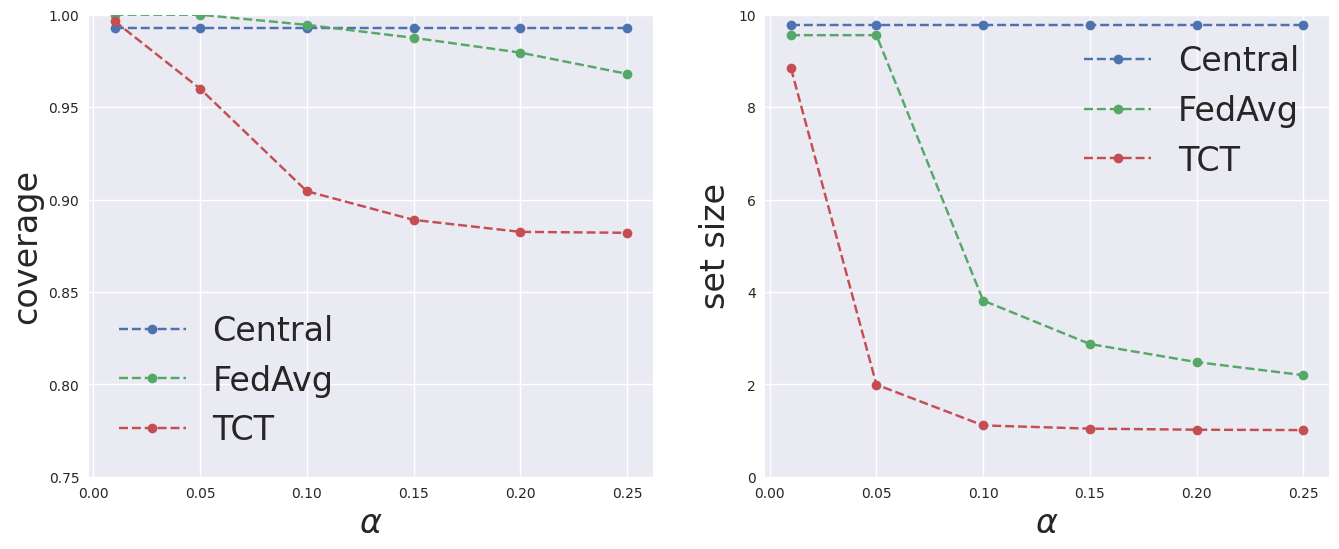

In [120]:
fontsize=24
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ax[0].plot(*zip(*cen_cov.items()), 'o--', label='Central')
ax[0].plot(*zip(*fed_cov.items()), 'o--', label='FedAvg')
ax[0].plot(*zip(*tct_cov.items()), 'o--', label='TCT')
ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0].set_ylabel(r'coverage', fontsize=fontsize)
ax[0].legend(fontsize=fontsize)
ax[1].plot(*zip(*cen_size.items()), 'o--', label='Central')
ax[1].plot(*zip(*fed_size.items()), 'o--', label='FedAvg')
ax[1].plot(*zip(*tct_size.items()), 'o--', label='TCT')
ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1].set_ylabel(r'set size', fontsize=fontsize)
ax[0].set_ylim(0.75, 1)
ax[1].set_ylim(0, 10)
ax[1].legend(fontsize=fontsize)
plt.show()

### inteprolating temperature scaling

In [114]:
def tune_temp(logits, labels, binary_search=True, lower=0.2, upper=5.0, eps=0.0001):
    logits = np.array(logits)

    if binary_search:
        import torch
        import torch.nn.functional as F

        logits = torch.FloatTensor(logits)
        labels = torch.LongTensor(labels)
        t_guess = torch.FloatTensor([0.5*(lower + upper)]).requires_grad_()

        while upper - lower > eps:
            if torch.autograd.grad(F.cross_entropy(logits / t_guess, labels), t_guess)[0] > 0:
                upper = 0.5 * (lower + upper)
            else:
                lower = 0.5 * (lower + upper)
            t_guess = t_guess * 0 + 0.5 * (lower + upper)

        t = min([lower, 0.5 * (lower + upper), upper], key=lambda x: float(F.cross_entropy(logits / x, labels)))
    else:
        import cvxpy as cx

        set_size = np.array(logits).shape[0]

        t = cx.Variable()

        expr = sum((cx.Minimize(cx.log_sum_exp(logits[i, :] * t) - logits[i, labels[i]] * t)
                    for i in range(set_size)))
        p = cx.Problem(expr, [lower <= t, t <= upper])

        p.solve()   # p.solve(solver=cx.SCS)
        t = 1 / t.value

    return t


In [115]:
import matplotlib as mpl

5.0
[1.0, 1.8, 2.6, 3.4, 4.2, 5.0]


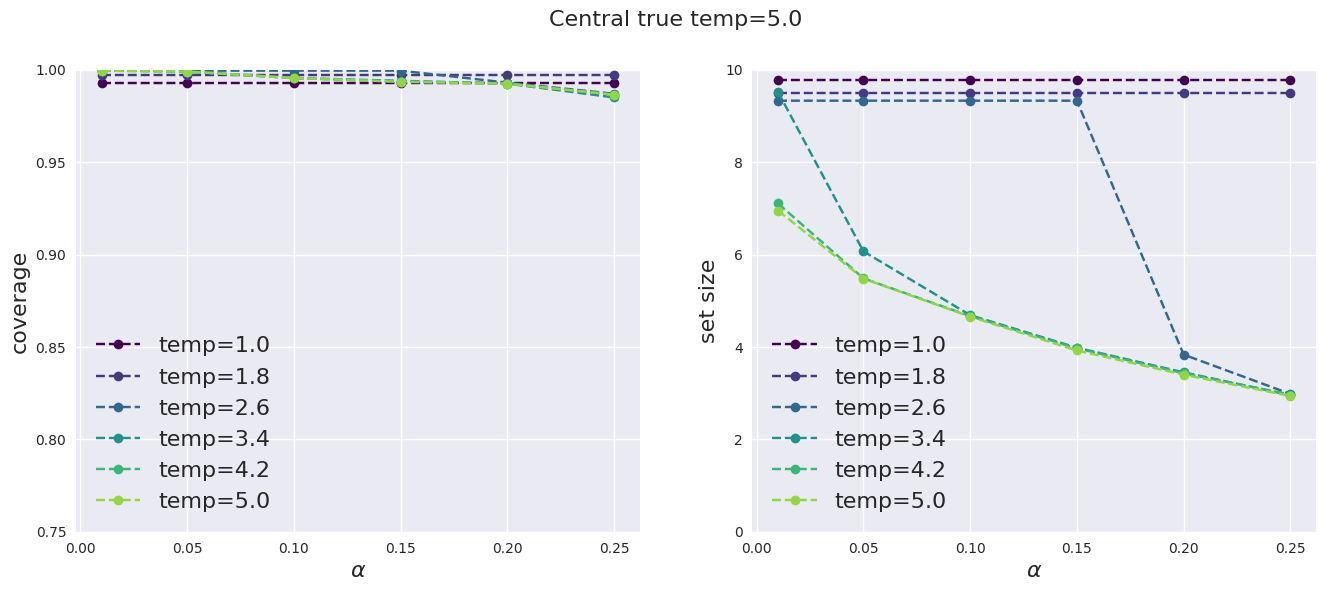

1.6612548828125
[1.0, 1.13, 1.26, 1.4, 1.53, 1.66]


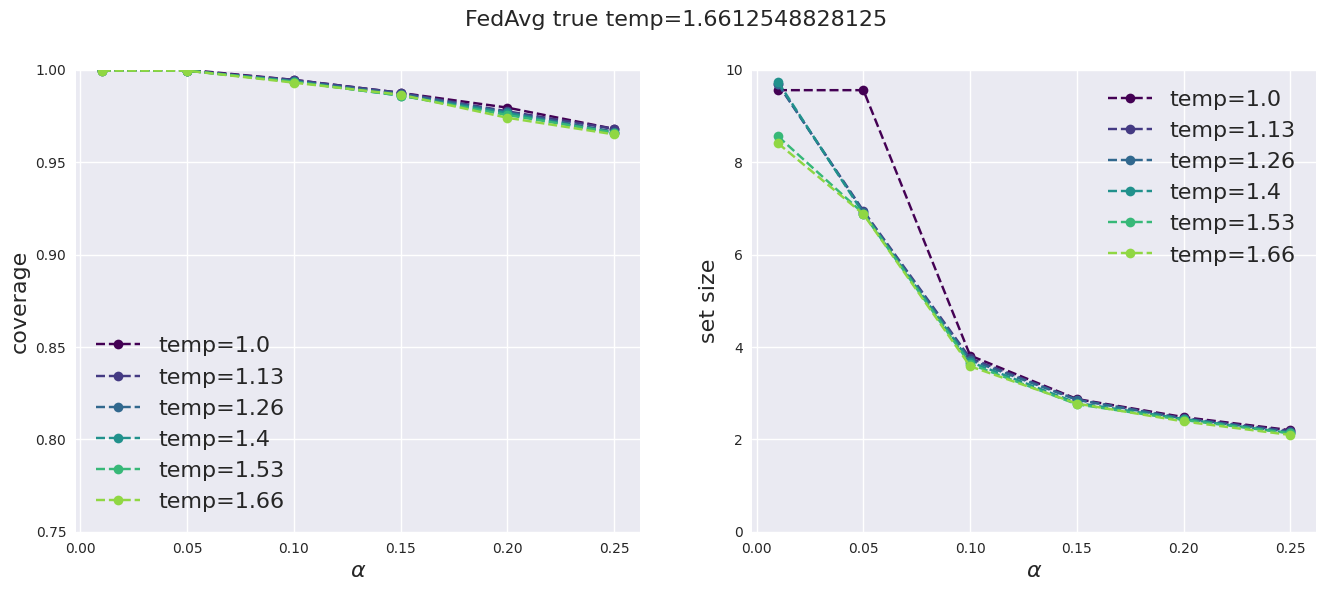

0.2
[1.0, 0.84, 0.68, 0.52, 0.36, 0.2]


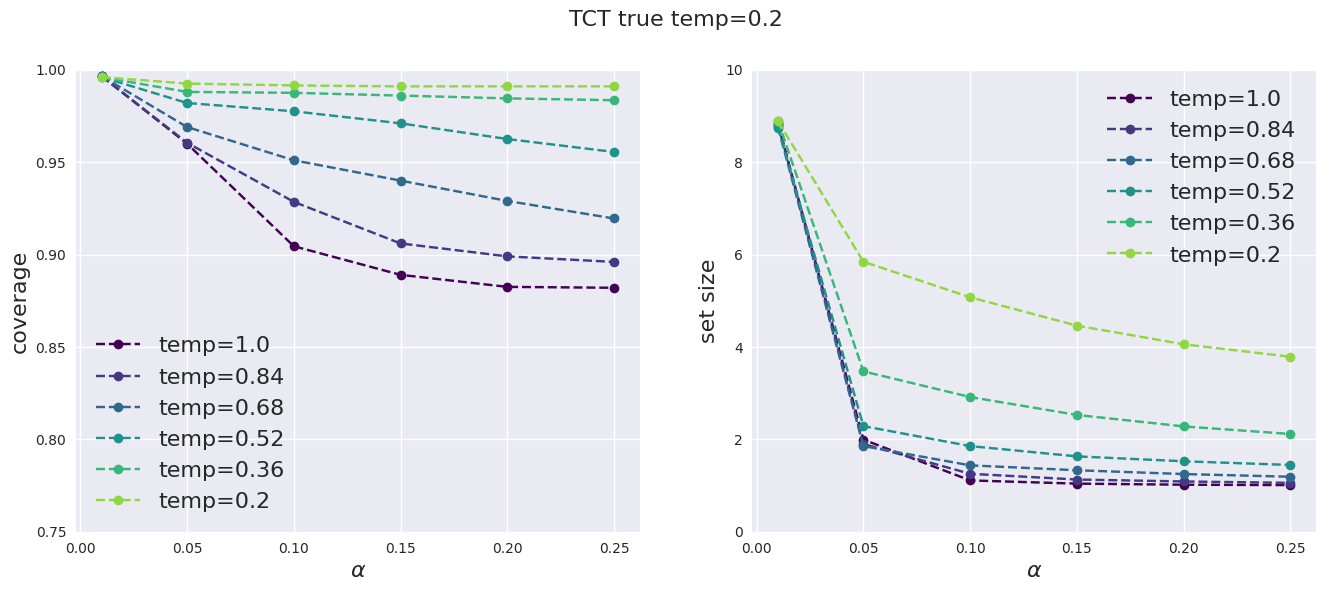

In [116]:
def plot_temp(val_scores, val_targets, test_scores, test_targets, num_interp=5, starting_temp=1, fontsize=16, title=None):
    
    end_temp = tune_temp(val_scores, val_targets, binary_search=True)
    # end_temp = temp_scale(val_scores, val_targets, False).item()
    print(end_temp)

    interp_temp = [round(x, 2) for x in np.linspace(starting_temp, end_temp, num_interp + 1)]
    print(interp_temp)
    # interp_temp = [0.001, 0.1, 1, 10, 20]
    interp_cmap = [round(x) for x in np.linspace(0, 256, num_interp + 2)]

    fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

    for i, temp in enumerate(interp_temp):
        label = f'temp={temp}'

        _val_scores = torch.softmax(val_scores / temp, 1)
        _test_scores = torch.softmax(test_scores / temp, 1)

        cov, size = get_conformal_metrics(_val_scores, val_targets, _test_scores, test_targets) 

        c = mpl.colormaps['viridis'].colors[interp_cmap[i]]
        ax[0].plot(*zip(*cov.items()), 'o--', label=label, c=c)
        ax[1].plot(*zip(*size.items()), 'o--', label=label, c=c)

    ax[0].legend(fontsize=fontsize)
    ax[1].legend(fontsize=fontsize)
    ax[0].set_ylim(0.75, 1)
    ax[1].set_ylim(0, 10)
    ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
    ax[0].set_ylabel(r'coverage', fontsize=fontsize)
    ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
    ax[1].set_ylabel(r'set size', fontsize=fontsize)
    fig.suptitle(title + f' true temp={end_temp}', fontsize=fontsize)
    plt.show()
    
    
plot_temp(cen_val_scores, cen_val_targets, cen_test_scores, cen_test_targets, title='Central')
plot_temp(fed_val_scores, fed_val_targets, fed_test_scores, fed_test_targets, title='FedAvg')
plot_temp(tct_val_scores, tct_val_targets, tct_test_scores, tct_test_targets, title='TCT')